In [5]:
import numpy as np
import keras.layers as kl
from joblib import dump, load
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import pad_sequences
from nltk.tokenize import word_tokenize
from keras.models import Sequential, load_model

In [16]:
# Carga de datos para el entrenamiento
y = []
x = []
with open("NOTICIAS DE LA AMAZONIA_CODEFEST.csv", encoding="utf-8") as csvfile:
    spamreader = csvfile.readlines()
    for row in spamreader:
        text = row.split("}")[0]
        text = text.lower()
        text = text.replace("á", "a")
        text = text.replace("é", "e")
        text = text.replace("í", "i")
        text = text.replace("ó", "o")
        text = text.replace("ú", "u")

        whitelist = set("abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ 0123456789")
        text = "".join(filter(whitelist.__contains__, text))

        label = "".join(filter(whitelist.__contains__, row.split("}")[1]))
    
        
        if (label == "CONTAMINACION"):
            y.append(0)
        elif (label == "DEFORESTACION"):
            y.append(1)
        elif (label == "MINERIA ILEGAL"):
            y.append(2)
        elif (label == "NARCOTRAFICO"):
            y.append(3)
        else:
            y.append(4)
        
        x.append(text)
        
y = np.array(y)
print(x[0])


la corte constitucional ordeno suspednder cualquier actividad minera en un millon de hectareas en los departamentos  de vaupes y amazonas


In [53]:
layer = kl.Hashing(num_bins=5000, output_mode="int", dtype="int32", mask_value=' ')
encoded_docs = [layer(word_tokenize(doc)).numpy() for doc in x]
max_length = max(len(subarr) for subarr in encoded_docs)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [54]:
# Creación del modelo
model = Sequential(
    [
        kl.Embedding(5000, 64, mask_zero=True),
        kl.Dropout(0.5),
        kl.Bidirectional(kl.LSTM(64, return_sequences=True)),
        kl.Dropout(0.5),
        kl.Bidirectional(kl.LSTM(32)),
        kl.Dropout(0.5),
        kl.Dense(64, activation="relu"),
        kl.Dropout(0.5),
        kl.Dense(5, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=Adam(1e-3), metrics=["acc"]
)
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 64)          320000    
                                                                 
 dropout_48 (Dropout)        (None, None, 64)          0         
                                                                 
 bidirectional_24 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 dropout_49 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 64)              

In [56]:
# Entrenamiento del modelo y guardado de los pesos
historial = model.fit(padded_docs, y, epochs=150, validation_split=0.2)

Epoch 1/150
14/14 [==============================] - 19s 494ms/step - loss: 1.6045 - acc: 0.2667 - val_loss: 1.5976 - val_acc: 0.2190
Epoch 2/150
14/14 [==============================] - 2s 177ms/step - loss: 1.5832 - acc: 0.3071 - val_loss: 1.5778 - val_acc: 0.2190
Epoch 3/150
14/14 [==============================] - 2s 166ms/step - loss: 1.5629 - acc: 0.2810 - val_loss: 1.5312 - val_acc: 0.3810
Epoch 4/150
14/14 [==============================] - 2s 166ms/step - loss: 1.4848 - acc: 0.3524 - val_loss: 1.4315 - val_acc: 0.3810
Epoch 5/150
14/14 [==============================] - 3s 183ms/step - loss: 1.2882 - acc: 0.4619 - val_loss: 1.1914 - val_acc: 0.4952
Epoch 6/150
14/14 [==============================] - 3s 180ms/step - loss: 1.0312 - acc: 0.5952 - val_loss: 0.8599 - val_acc: 0.7524
Epoch 7/150
14/14 [==============================] - 2s 179ms/step - loss: 0.7869 - acc: 0.7143 - val_loss: 0.8472 - val_acc: 0.7143
Epoch 8/150
14/14 [==============================] - 2s 171ms/step -

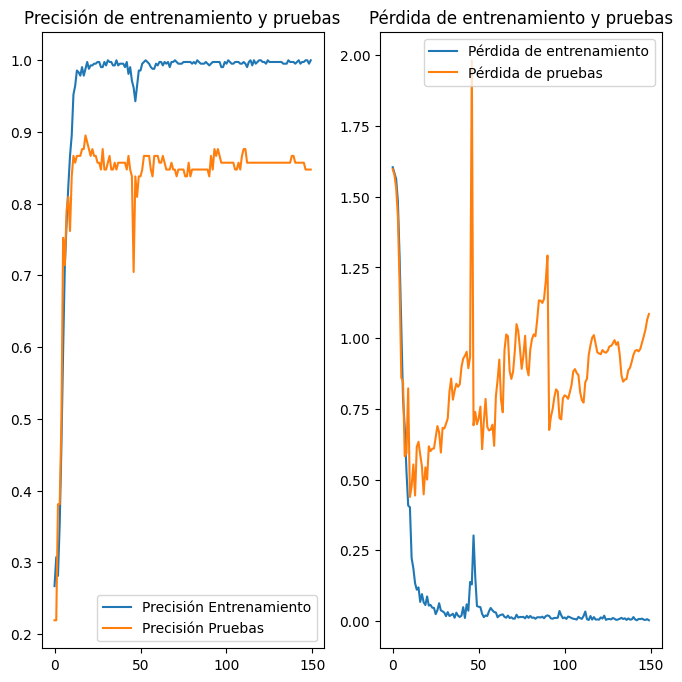

In [58]:
# Gráfica de la precisión y la pérdida
acc = historial.history["acc"]
val_acc = historial.history["val_acc"]

loss = historial.history["loss"]
val_loss = historial.history["val_loss"]

rango_epocas = range(150)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(rango_epocas, acc, label="Precisión Entrenamiento")
plt.plot(rango_epocas, val_acc, label="Precisión Pruebas")
plt.legend(loc="lower right")
plt.title("Precisión de entrenamiento y pruebas")

plt.subplot(1, 2, 2)
plt.plot(rango_epocas, loss, label="Pérdida de entrenamiento")
plt.plot(rango_epocas, val_loss, label="Pérdida de pruebas")
plt.legend(loc="upper right")
plt.title("Pérdida de entrenamiento y pruebas")
plt.show()

In [62]:
model.save("ACPM1111.h5")
dump(layer, 'hash.joblib')

['hash.joblib']

In [14]:
model = load_model("ACPM1111.h5")
layer = load("hash.joblib")
max_length = 164

In [15]:
# Pruebas de predicción
test = [
    "Operativo policial desmantela red de narcotráfico internacional en América Latina.",
    "Informe revela aumento alarmante de la deforestación en la Amazonía durante el último año.",
    "Autoridades decomisan toneladas de drogas en operativo contra el narcotráfico en el Caribe.",
    "Minería ilegal en una reserva natural amenaza la biodiversidad y los ecosistemas locales.",
    "Narcotraficantes utilizan nuevas rutas y técnicas para evadir los controles de seguridad.",
    "Deforestación en una zona protegida pone en peligro el hábitat de especies en peligro de extinción.",
    "Autoridades desmantelan banda dedicada a la minería ilegal de oro en una región montañosa.",
    "Incautan cargamento de drogas valuado en millones de dólares en un operativo antidrogas.",
    "Expertos alertan sobre los impactos devastadores de la deforestación en el cambio climático.",
    "Narcotraficantes utilizan métodos sofisticados para ocultar drogas en envíos legítimos.",
    "Comunidades indígenas denuncian la destrucción de sus tierras por la minería ilegal.",
    "Informe destaca los vínculos entre la deforestación y la pérdida de biodiversidad en el mundo.",
    "Cae red de narcotráfico que operaba en una zona fronteriza, asegurando múltiples arrestos.",
    "Organizaciones ambientales luchan contra la deforestación en una región crítica para la conservación.",
    "Autoridades intensifican las acciones contra la minería ilegal en un esfuerzo por proteger los recursos naturales y las comunidades afectadas."
    ]

for text in test:
    text = text.lower()
    text = text.replace("á", "a")
    text = text.replace("é", "e")
    text = text.replace("í", "i")
    text = text.replace("ó", "o")
    text = text.replace("ú", "u")

    whitelist = set("abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ 0123456789")
    text = "".join(filter(whitelist.__contains__, text))
    
    print(text)

    nombres_clases = [
        "CONTAMINACION",
        "DEFORESTACION",
        "MINERIA",
        "NINGUNA",
        "NINGUNA",
    ]
    
    encoded_test = [layer(word_tokenize(text)).numpy()]
    padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
    print(nombres_clases[np.argmax(model.predict(padded_test))])

operativo policial desmantela red de narcotrafico internacional en america latina
1/1 [==============================] - 10s 10s/step
NINGUNA
informe revela aumento alarmante de la deforestacion en la amazonia durante el ultimo año
1/1 [==============================] - 0s 73ms/step
DEFORESTACION
autoridades decomisan toneladas de drogas en operativo contra el narcotrafico en el caribe
1/1 [==============================] - 0s 79ms/step
NINGUNA
mineria ilegal en una reserva natural amenaza la biodiversidad y los ecosistemas locales
1/1 [==============================] - 0s 83ms/step
MINERIA
narcotraficantes utilizan nuevas rutas y tecnicas para evadir los controles de seguridad
1/1 [==============================] - 0s 85ms/step
NINGUNA
deforestacion en una zona protegida pone en peligro el habitat de especies en peligro de extincion
1/1 [==============================] - 0s 91ms/step
DEFORESTACION
autoridades desmantelan banda dedicada a la mineria ilegal de oro en una region montaños